In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class GE_Thyroid_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        image_type = self.df["image_type"][idx]

        if image_type == "train":
            from_folder = "../ge_data/train"
        else:
            from_folder = "../ge_data/test"

        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()

        return image_tensor, mask_tensor, mask_name, image_type

In [48]:
image_size = 128
batch_size = 128
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor

train_dataset = GE_Thyroid_Dataset("../ge_data/train_csv_for_finetune(0.1).csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = GE_Thyroid_Dataset("../ge_data/test_csv_for_finetune_all.csv", transform = test_augmentation, image_size = image_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

image, mask, mask_name, image_type = next(iter(train_dataloader))

In [52]:
print(len(train_dataset), len(test_dataset))

56 112


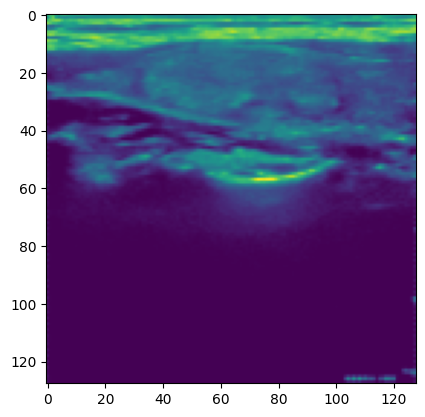

In [50]:
plt.imshow(image[10][0])

In [61]:

inference_name = "hybrid_v3_baseline"

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
loss_fn = StructureLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
lr = 0.01
model.to("cuda")
image = image.to("cuda")
mask = mask.to("cuda")
for epoch in range(100):
    outputs = model(image)
        
    output = outputs[:, 0:1, :, :]
    
    
    loss = loss_fn(output, mask)

    IOU = IOU_score(output, mask)

    dice_loss = DiceLoss()
    DICE = 1 - dice_loss(output, mask)

    
    # Backward and optimize
    optimizer.zero_grad()   # clear previous gradients
    loss.backward()         # compute gradients
    optimizer.step()        # update weights
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, IOU: {IOU.item():.4f}, DICE: {DICE.item()}")

Epoch 1, Loss: 3.4430, IOU: 0.1576, DICE: 0.3058069944381714
Epoch 2, Loss: 2.4288, IOU: 0.0132, DICE: 0.031785428524017334
Epoch 3, Loss: 1.4299, IOU: 0.1040, DICE: 0.17694640159606934
Epoch 4, Loss: 1.2252, IOU: 0.1232, DICE: 0.1627742052078247
Epoch 5, Loss: 1.0636, IOU: 0.1544, DICE: 0.20304012298583984
Epoch 6, Loss: 1.0186, IOU: 0.1041, DICE: 0.20359253883361816
Epoch 7, Loss: 1.0028, IOU: 0.0782, DICE: 0.20940715074539185
Epoch 8, Loss: 0.9781, IOU: 0.1164, DICE: 0.23842912912368774
Epoch 9, Loss: 0.9582, IOU: 0.1646, DICE: 0.26858824491500854
Epoch 10, Loss: 0.9538, IOU: 0.1856, DICE: 0.2868896722793579
Epoch 11, Loss: 0.9327, IOU: 0.1999, DICE: 0.30179446935653687
Epoch 12, Loss: 0.9169, IOU: 0.2004, DICE: 0.31019335985183716
Epoch 13, Loss: 0.9539, IOU: 0.1397, DICE: 0.2805877923965454
Epoch 14, Loss: 0.9046, IOU: 0.2181, DICE: 0.33352112770080566
Epoch 15, Loss: 0.9075, IOU: 0.2190, DICE: 0.339316189289093
Epoch 16, Loss: 0.8871, IOU: 0.2294, DICE: 0.3511725068092346
Epoch 1

In [55]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        # count+=1
        # if count==5:
        #     break
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)
    

        total_loss += loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


    

In [39]:
epochs = 50
lr = 0.01
project = "thyroid_ge_finetune"
# name = "hybrid_model_baseline(0.1)"
name = "test"
wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [40]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.01, epochs : 50, batch size : 128


In [56]:

inference_name = "hybrid_v3_baseline"

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<All keys matched successfully>

In [57]:
# loss_fn = DiceLoss()
loss_fn = StructureLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [58]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
#     total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
#     print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
#     scheduler.step()
#     current_lr = scheduler.get_last_lr()[0]



#     if max_IOU < total_IOU_val:
#         max_IOU = total_IOU_val
#         checkpoint = {
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'scheduler_state_dict': scheduler.state_dict(),
#             "IOU" : total_IOU_val,
#             "DICE" : total_DICE_val,
#             "loss" : total_loss_val
#         }
#         folder = f"models/{name}"
#         if not os.path.exists(folder):
#             os.mkdir(folder)
#         torch.save(checkpoint, f"models/{name}/best_checkpoint.pth")

    
#     wandb.log({
#         "epoch": epoch,
#         "Learning Rate":current_lr,
        
#         "train_loss": total_loss_train,
#         "train_IOU": total_IOU_train,
#         "train_DICE": total_DICE_train,
        
#         "val_loss": total_loss_val,
#         "val_IOU": total_IOU_val,
#         "val_DICE": total_DICE_val,
        
#     })




# checkpoint = {
#     'epoch': epoch,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'scheduler_state_dict': scheduler.state_dict(),
#     "IOU" : total_IOU_val,
#     "DICE" : total_DICE_val,
#     "loss" : total_loss_val
# }
# if not os.path.exists(folder):
#     os.mkdir(folder)
# torch.save(checkpoint, f"models/{name}/last_checkpoint.pth")
# wandb.finish()

epoch : 0


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 3.443044662475586, train IOU : 0.157612606883049, train DICE : 0.3058069944381714
epoch : 1


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 2.4286766052246094, train IOU : 0.013178491033613682, train DICE : 0.03177690505981445
epoch : 2


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 1.4302808046340942, train IOU : 0.1035868376493454, train DICE : 0.17663288116455078
epoch : 3


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 1.2241655588150024, train IOU : 0.12387446314096451, train DICE : 0.16326826810836792
epoch : 4


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 1.063372254371643, train IOU : 0.154713973402977, train DICE : 0.20335865020751953
epoch : 5


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 1.0182889699935913, train IOU : 0.10428043454885483, train DICE : 0.20402413606643677
epoch : 6


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 1.0024833679199219, train IOU : 0.07828494906425476, train DICE : 0.2097894549369812
epoch : 7


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.977679431438446, train IOU : 0.11630143225193024, train DICE : 0.23881876468658447
epoch : 8


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.9577126502990723, train IOU : 0.1648196578025818, train DICE : 0.2689981460571289
epoch : 9


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.9532908201217651, train IOU : 0.18581481277942657, train DICE : 0.28733760118484497
epoch : 10


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


train loss : 0.9322354197502136, train IOU : 0.20034141838550568, train DICE : 0.3021818995475769
epoch : 11


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.9162764549255371, train IOU : 0.20159929990768433, train DICE : 0.3106095790863037
epoch : 12


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.9560467004776001, train IOU : 0.13727501034736633, train DICE : 0.2788759469985962
epoch : 13


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.9037229418754578, train IOU : 0.21895462274551392, train DICE : 0.3342336416244507
epoch : 14


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.9066357612609863, train IOU : 0.21996428072452545, train DICE : 0.34000611305236816
epoch : 15


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.8851653337478638, train IOU : 0.23147308826446533, train DICE : 0.3523446321487427
epoch : 16


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.8721562623977661, train IOU : 0.24406081438064575, train DICE : 0.3645820617675781
epoch : 17


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.8766303062438965, train IOU : 0.2489262819290161, train DICE : 0.37575531005859375
epoch : 18


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


train loss : 0.8408620357513428, train IOU : 0.26956674456596375, train DICE : 0.398601770401001
epoch : 19


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.8262789249420166, train IOU : 0.27224957942962646, train DICE : 0.40796297788619995
epoch : 20


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.8121699094772339, train IOU : 0.29590049386024475, train DICE : 0.4256424307823181
epoch : 21


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.8101924061775208, train IOU : 0.30377665162086487, train DICE : 0.42386627197265625
epoch : 22


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.8055728077888489, train IOU : 0.29455894231796265, train DICE : 0.44406354427337646
epoch : 23


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


train loss : 0.7759473323822021, train IOU : 0.33022117614746094, train DICE : 0.4602741003036499
epoch : 24


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.757806122303009, train IOU : 0.3351122736930847, train DICE : 0.4881683588027954
epoch : 25


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.7460679411888123, train IOU : 0.34530705213546753, train DICE : 0.5013954639434814
epoch : 26


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.7864100933074951, train IOU : 0.315186083316803, train DICE : 0.4807623624801636
epoch : 27


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.7531067132949829, train IOU : 0.33943697810173035, train DICE : 0.48578572273254395
epoch : 28


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.7741970419883728, train IOU : 0.3304067850112915, train DICE : 0.48519325256347656
epoch : 29


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.7237870693206787, train IOU : 0.35498136281967163, train DICE : 0.5155723690986633
epoch : 30


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


train loss : 0.7249175906181335, train IOU : 0.3743153512477875, train DICE : 0.5207530856132507
epoch : 31


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.7030850052833557, train IOU : 0.3867207467556, train DICE : 0.5223907828330994
epoch : 32


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.6984272599220276, train IOU : 0.3934778571128845, train DICE : 0.5258070826530457
epoch : 33


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.6722756028175354, train IOU : 0.411112517118454, train DICE : 0.5539308786392212
epoch : 34


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.6645209789276123, train IOU : 0.44153738021850586, train DICE : 0.5814277529716492
epoch : 35


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


train loss : 0.6431130766868591, train IOU : 0.4444928467273712, train DICE : 0.5954827070236206
epoch : 36


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.7116779088973999, train IOU : 0.36213794350624084, train DICE : 0.5497382283210754
epoch : 37


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.7127777338027954, train IOU : 0.3769102990627289, train DICE : 0.5499523282051086
epoch : 38


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.6747421622276306, train IOU : 0.4065399467945099, train DICE : 0.565811276435852
epoch : 39


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


train loss : 0.6601400375366211, train IOU : 0.42051923274993896, train DICE : 0.5792573690414429
epoch : 40


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.6344563364982605, train IOU : 0.478701114654541, train DICE : 0.6094513535499573
epoch : 41


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


train loss : 0.6283372044563293, train IOU : 0.44298696517944336, train DICE : 0.6076174974441528
epoch : 42


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.6102782487869263, train IOU : 0.45788073539733887, train DICE : 0.6187433004379272
epoch : 43


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.6197380423545837, train IOU : 0.47352996468544006, train DICE : 0.6287919282913208
epoch : 44


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.6075804829597473, train IOU : 0.4469386637210846, train DICE : 0.6240260004997253
epoch : 45


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


train loss : 0.5699392557144165, train IOU : 0.4841030538082123, train DICE : 0.655449390411377
epoch : 46


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


train loss : 0.5691079497337341, train IOU : 0.5029183030128479, train DICE : 0.6689360737800598
epoch : 47


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


train loss : 0.6216198205947876, train IOU : 0.43755847215652466, train DICE : 0.6250410676002502
epoch : 48


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


train loss : 0.5204899907112122, train IOU : 0.5236183404922485, train DICE : 0.6946182250976562
epoch : 49


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

train loss : 0.5527198910713196, train IOU : 0.5293310284614563, train DICE : 0.6848083138465881


In [ ]:
# inference_name = "PMFSNet_finetune_baseline_v4(0.9)"
# # model = HarDMSEG(in_channels = 1)
# model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# # model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
# checkpoint = torch.load(f"models/{inference_name}/last_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# # scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [ ]:
# image, mask, seg_type, from_dataset = next(iter(test_dataloader))
# model.to("cpu")
# outputs = model(image)
# print(outputs.shape)

In [ ]:
# index = 20
# plt.subplot(1,2,1)
# plt.imshow(image[index][0])
# plt.imshow(mask[index][0], alpha = 0.5)
# plt.title("label")

# outputs = outputs>0.5
# plt.subplot(1,2,2)
# plt.imshow(image[index][0])
# plt.imshow(outputs[index][0].detach().cpu().numpy(), alpha = 0.5)
# plt.title("prediction")